In [1]:
from main import *
from useful_functions import *
from visualization import *

from scipy.stats import ttest_ind
import bct
import seaborn

%matplotlib inline
plt.rcParams['font.size'] = 6

# Setting paths

In [2]:
top_directory = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/'
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'

In [3]:
atlas = MapzebrainAtlas(atlas_path)
centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
excluded = np.load('Results/excluded_regions.npy')

centroids_ = np.delete(centroids, np.concatenate([excluded, excluded + 70]), axis=0)

In [4]:
datasets = get_datasets(top_directory, keywords=['920nm'], exclude=[])
print(len(datasets))

22


In [5]:
W_dir = np.load('Results/directed_terminals_expanded.npy')
W_und = np.load('Results/undirected_terminals_expanded.npy')
FC = np.load('Results/FC_matrix.npy')

In [6]:
delete = delete_rows_and_columns

# Loading stuff

In [16]:
coassignment_matrix_SC = np.load('Results/coassignment_matrix_SC_expanded.npy')
coassignment_matrix_FC = np.load('Results/coassignment_matrix_FC.npy')

modularities_SC = np.load('Results/figure3_modularities_SC.npy')
modularities_FC = np.load('Results/figure3_modularities_FC.npy')

overlaps = np.load('Results/figure3_overlaps.npy')
communities_labels = np.load('Results/figure3_communities_labels.npy')

# Figure layout

#### Testing color palettes

In [133]:
def rgb2hex(rgb_color):
    """Convert RGB color values to HEX code."""
    if rgb_color.dtype == 'float' and np.sum(rgb_color <=1) == 3:
        rgb_color = (rgb_color * 255).astype('int')
    r, g, b = rgb_color
    return "#{:02x}{:02x}{:02x}".format(r, g, b)

def get_colors_cmap(cmap, n_colors, start=0, end=1, hex=False):
    sampling_points = np.linspace(start, end, n_colors, endpoint=True).astype('float')
    colors = []
    for s in sampling_points:
        rgb_color = plt.get_cmap(cmap)(s)[:3]
        if hex:
            hex_color = rgb2hex((np.array(rgb_color) * 255).astype('int'))
            colors.append(hex_color)
        else:
            colors.append(rgb_color)
    return colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap)
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

In [123]:
cmap = plt.get_cmap('rainbow')

In [146]:
cmap1 = 'Purples'
#cmap2 = truncate_colormap('turbo', 0.05, 0.95)
cmap2 = 'rainbow'
colors = []
indices = np.linspace(0, 1, 4, endpoint=True)
for i in indices:
    colors.append(rgb2hex(np.array(plt.get_cmap(cmap2)(i)[:3])))
set_link_color_palette(colors)

In [147]:
color = hex2rgb(colors[-1])
colors_FC = color_gradient(color, [1, 1, 1], 5)

color = hex2rgb(colors[0])
colors_SC = color_gradient(color, [1, 1, 1], 6)

colors_overlaps = []
indices = np.linspace(0, 1, 5, endpoint=True)
for i in indices:
    colors_overlaps.append(rgb2hex(np.array(plt.get_cmap(cmap2)(i)[:3])))

%matplotlib inline
plt.scatter(1, 1, color=colors[0], s=100)
plt.scatter(2, 2, color=colors[1], s=100)
plt.scatter(3, 3, color=colors[2], s=100)
plt.scatter(4, 4, color=colors[3], s=100)
plt.show()

#### Rendering

In [148]:
N_communities = 4

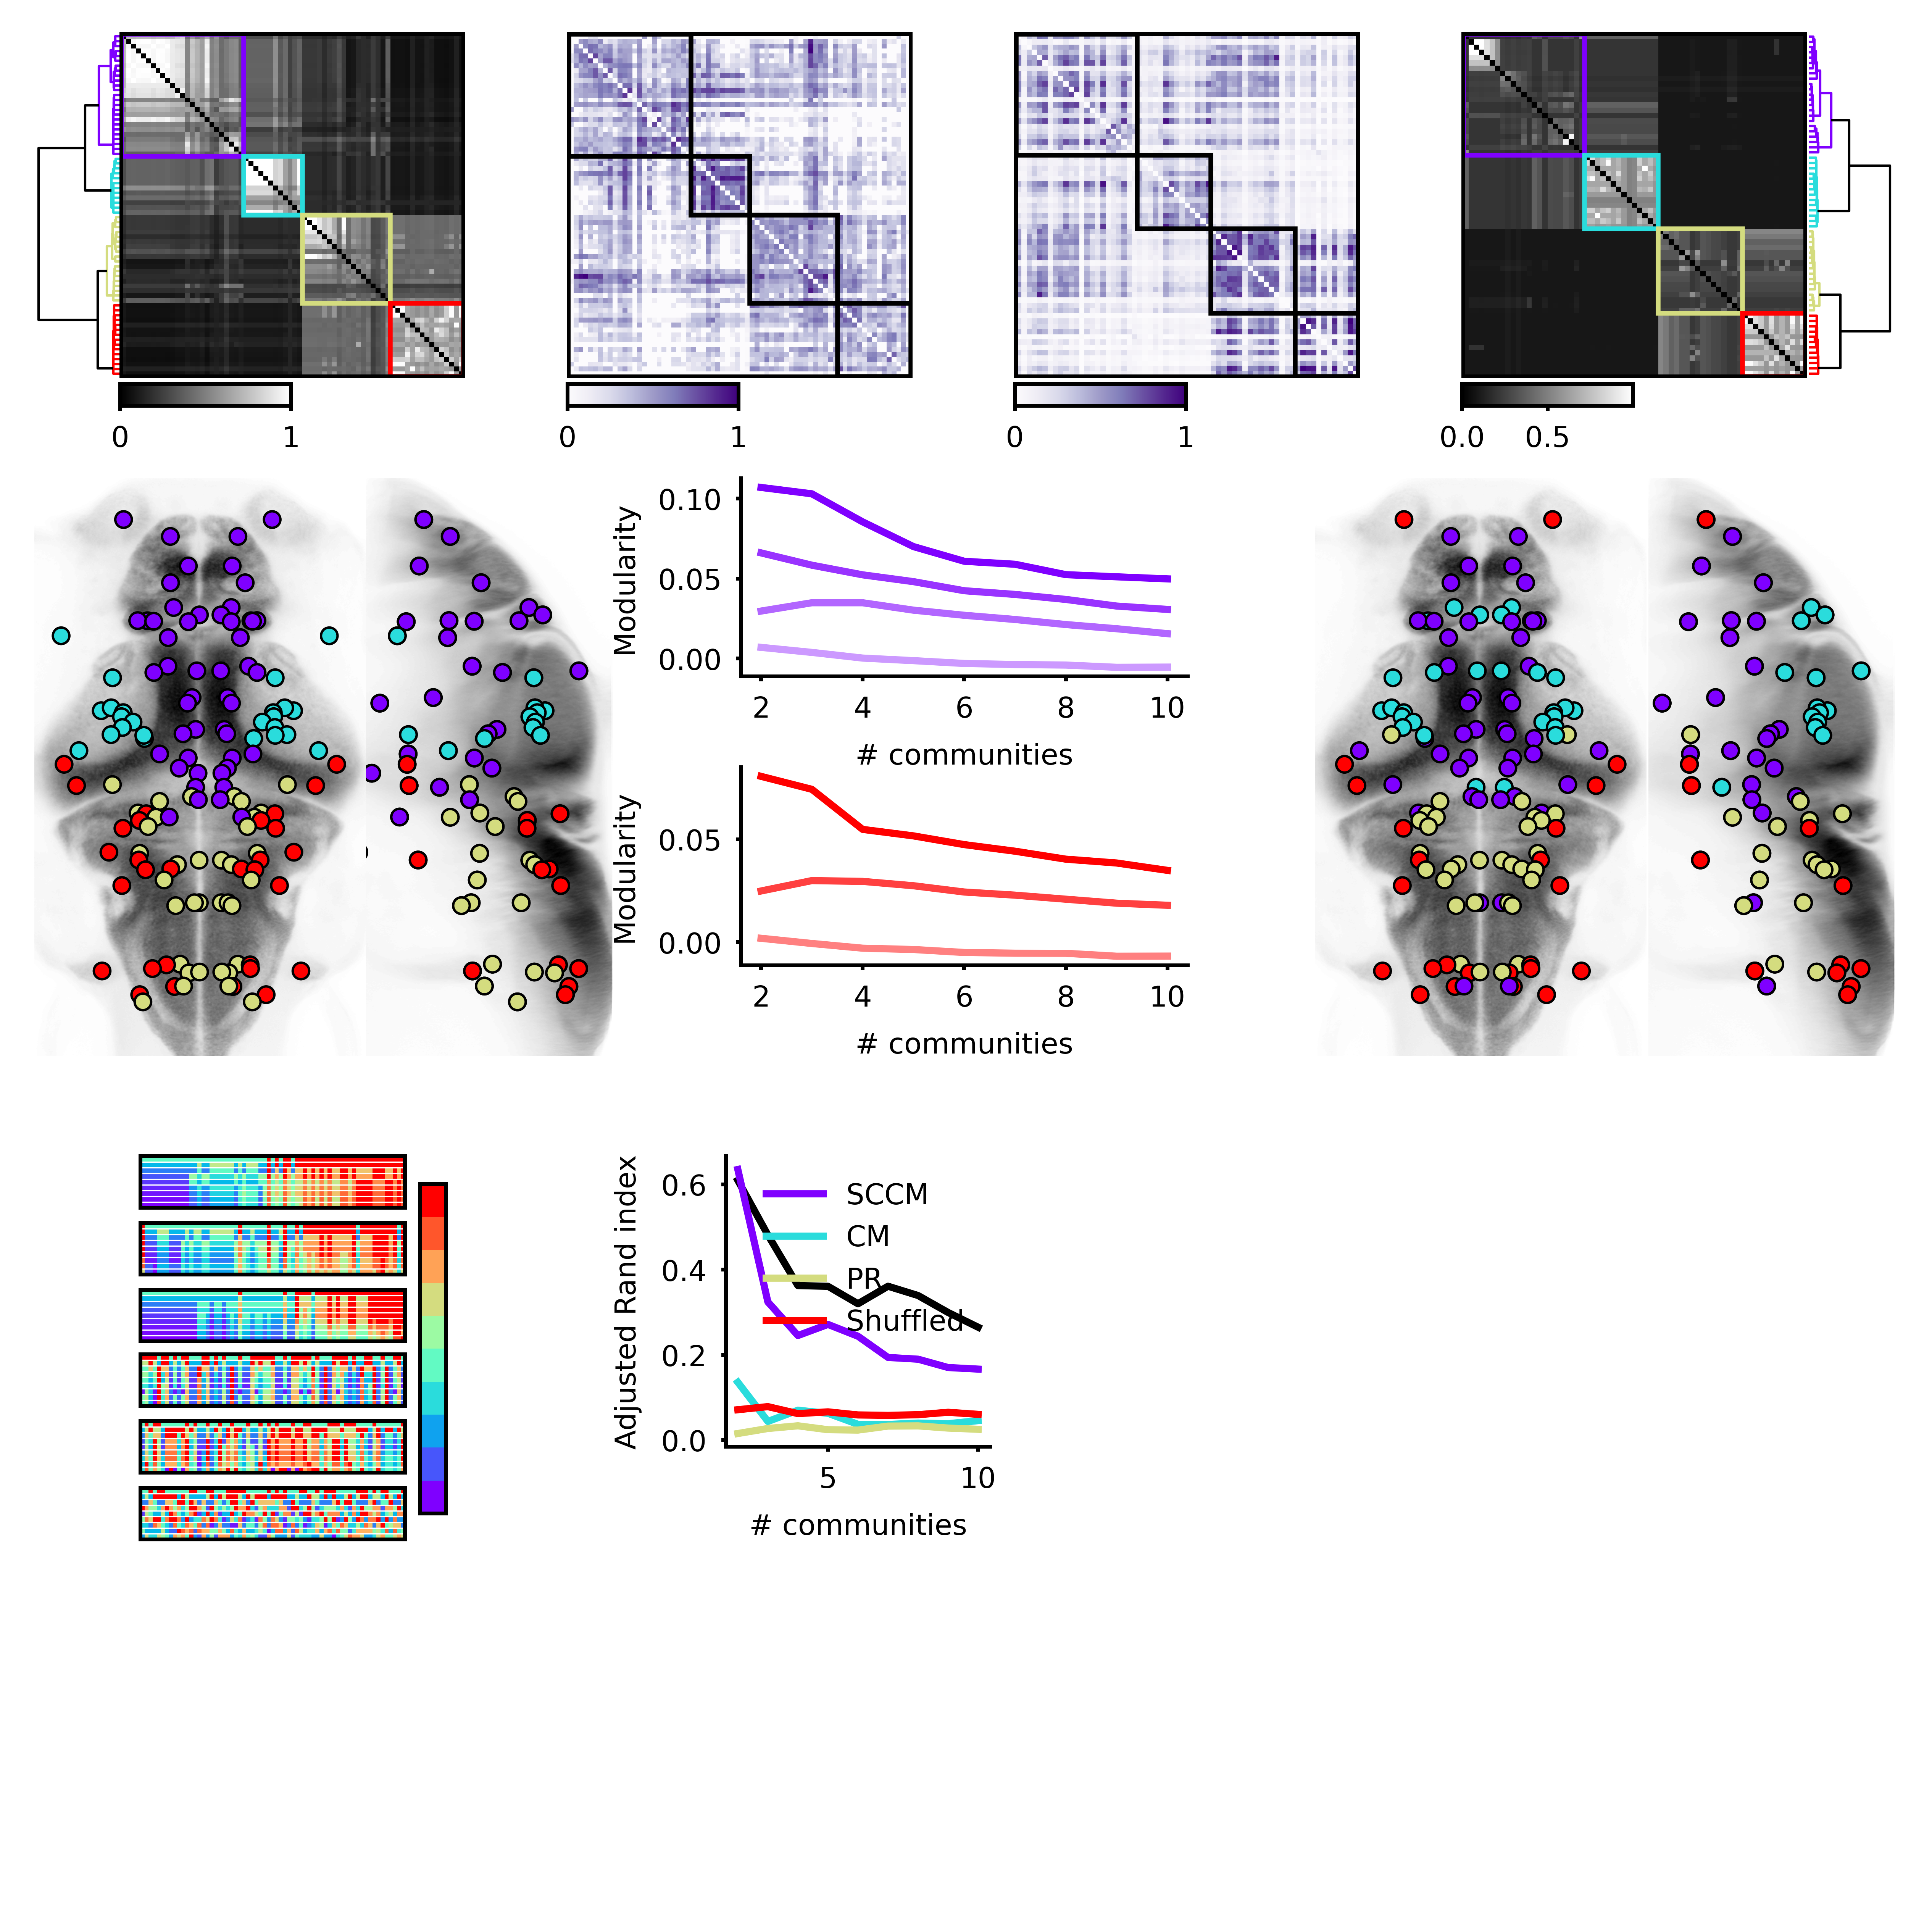

In [152]:
fig = PaperFigure(figsize=(7, 7), dpi=900)

fig.set_tick_length(1)
fig.set_font_size(6)
fig.add_background() # Useful when messing with the layout

# Layout ------------------------------------------------------------------------------------

# First row
x = 1.3
pad = 0.38
fig.add_axes('a1', (0, 0), x / 4, x)
fig.add_axes('a2', (x / 4, 0), x, x)
fig.add_axes('a_colorbar', (x / 4, x + 0.025), x/2, x/15)

fig.add_axes('b', (1.25 * x + pad, 0), x, x)
fig.add_axes('b_colorbar', (1.25 * x + pad, x + 0.025), x/2, x/15)

fig.add_axes('c', (2.25 * x + 2 * pad, 0), x, x)
fig.add_axes('c_colorbar', (2.25 * x + 2 * pad, x + 0.025), x/2, x/15)

fig.add_axes('d1', (3.25 * x + 3 * pad, 0), x, x)
fig.add_axes('d2', (4.25 * x + 3 * pad, 0), x / 4, x)
fig.add_axes('d_colorbar', (3.25 * x + 3 * pad, x + 0.025), x/2, x/15)


# Second row
w2 = 1.25
ratio = 1.75
fig.add_axes('e1', (0, x+pad), w2, ratio * w2)
fig.add_axes('e2', (w2, x+pad), 0.75 * w2, ratio * w2)

fig.add_axes('f1', (7 - 1.75 * w2, x+pad), w2, ratio * w2)
fig.add_axes('f2', (7 - 0.75 * w2, x+pad), 0.75 * w2, ratio * w2)

fig.add_axes('modularities_SC', (2.25 * x + pad - x/2, x + pad), x + pad, 0.75)
fig.add_axes('modularities_FC', (2.25 * x + pad - x/2, x + pad + (ratio * w2)/2), x + pad, 0.75)

# Third row
y3 = x + pad + ratio * w2 + pad
pad = 0.05
delta_y = 0.2
x = 0.4
fig.add_axes('labels1', (x, y3), 1, delta_y)
fig.add_axes('labels2', (x, y3 + delta_y + pad), 1, delta_y)
fig.add_axes('labels3', (x, y3 + 2 * (delta_y + pad)), 1, delta_y)
fig.add_axes('labels4', (x, y3 + 3 * (delta_y + pad)), 1, delta_y)
fig.add_axes('labels5', (x, y3 + 4 * (delta_y + pad)), 1, delta_y)
fig.add_axes('labels6', (x, y3 + 5 * (delta_y + pad)), 1, delta_y)
fig.add_axes('labels_colorbar', (x + 1 + pad, y3 + delta_y / 2), 0.1, 5 * (delta_y + pad))

fig.add_axes('overlap', (x + 2.2, y3), 1, 1.1)


# Content -----------------------------------------------------------------------------------

# SC coassignment 
ax = fig.axes['a2']
C = coassignment_matrix_SC
Z = linkage(1 - C, 'ward')
ids_Z = np.flip(leaves_list(Z)).astype('int')
communities_SC = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
im = plot_matrix_communities(ax, C[ids_Z, :][:, ids_Z], communities_SC[ids_Z], linewidth=1, cmap='gray', colors=colors, edgecolor='red', output=True)
plt.colorbar(im, cax=fig.axes['a_colorbar'], orientation='horizontal')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['a1']
set_link_color_palette(list(np.flip(colors)))
ids_Z = leaves_list(Z)
threshold = Z[:, 2][-N_communities] + 1e-10
with plt.rc_context({'lines.linewidth': 0.5}):
    dendrogram(Z, ax=ax, above_threshold_color='black', orientation='left', color_threshold=threshold)
ax.axis('off')

# SC matrix, reordered
ax = fig.axes['b']
im = plot_matrix_communities(ax, W_und ** 2, communities_SC, linewidth=1, cmap=cmap1, edgecolor='black', output=True)
plt.colorbar(im, cax=fig.axes['b_colorbar'], orientation='horizontal')
ax.set_xticks([])
ax.set_yticks([])

# FC coassignment
ax = fig.axes['d1']
C = coassignment_matrix_FC
Z = linkage(1 - C, 'ward')
ids_Z = np.flip(leaves_list(Z)).astype('int')
communities_FC = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
im = plot_matrix_communities(ax, C[ids_Z, :][:, ids_Z], communities_FC[ids_Z], linewidth=1, cmap='gray', colors=colors, edgecolor='red', output=True)
plt.colorbar(im, cax=fig.axes['d_colorbar'], orientation='horizontal')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['d2']
ids_Z = leaves_list(Z)
threshold = Z[:, 2][-N_communities] + 1e-10
with plt.rc_context({'lines.linewidth': 0.5}):
    dendrogram(Z, ax=ax, above_threshold_color='black', orientation='right', color_threshold=threshold)
ax.axis('off')

# FC matrix, reordered
ax = fig.axes['c']
im = plot_matrix_communities(ax, (FC / np.max(FC)) ** 2, communities_FC, linewidth=1, cmap=cmap1, edgecolor='black', output=True)
plt.colorbar(im, cax=fig.axes['c_colorbar'], orientation='horizontal')
ax.set_xticks([])
ax.set_yticks([])

# Structural communities on atlas

ax = fig.axes['e1']
ax.imshow(atlas.XYprojection, cmap='binary', aspect='auto')
ax.scatter(centroids[:, 0], centroids[:, 1], edgecolor='black', linewidth=0.5,
           color=double(np.array(colors)[communities_SC - 1]), cmap='rainbow', s=12)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = fig.axes['e2']
ax.imshow(np.rot90(atlas.XZprojection, k=3), cmap='binary', aspect='auto')
ax.scatter(359 - centroids[:, 2], centroids[:, 1], edgecolor='black', linewidth=0.5,
           color=double(np.array(colors)[communities_SC - 1]), cmap='rainbow', s=12)
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = fig.axes['f1']
ax.imshow(atlas.XYprojection, cmap='binary', aspect='auto')

ax.scatter(centroids_[:, 0], centroids_[:, 1], edgecolor='black', linewidth=0.5,
           color=double(np.array(colors)[communities_FC - 1]), cmap='rainbow', s=12)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = fig.axes['f2']
ax.imshow(np.rot90(atlas.XZprojection, k=3), cmap='binary', aspect='auto')
ax.scatter(359 - centroids_[:, 2], centroids_[:, 1], edgecolor='black', linewidth=0.5,
           color=double(np.array(colors)[communities_FC - 1]), cmap='rainbow', s=12)

ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = fig.axes['modularities_SC']
ax.spines[['top', 'right']].set_visible(False)
for i, m in enumerate(modularities_SC):
    ax.plot(np.arange(2, 11), m, color=colors_SC[i])
ax.set_xlabel('# communities')
ax.set_ylabel('Modularity')

ax = fig.axes['modularities_FC']
ax.spines[['top', 'right']].set_visible(False)
for i, m in enumerate(modularities_FC):
    ax.plot(np.arange(2, 11), m, color=colors_FC[i])
ax.set_xlabel('# communities')
ax.set_ylabel('Modularity')

for i, name in enumerate(['labels1', 'labels2', 'labels3', 'labels4', 'labels5', 'labels6']):
    ax = fig.axes[name]
    ax.imshow(communities_labels[i], cmap=cmap2, aspect='auto', interpolation='None')
    for j in range(8):
        ax.plot([0, 64], [j + 0.5, j + 0.5], color='white', linewidth=0.25)
    ax.set_xticks([])
    ax.set_yticks([])

ax = fig.axes['labels_colorbar']
N = len(np.unique(communities_labels[0][-1, :]))
vector = np.flip(np.arange(N)).reshape(N, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(vector, aspect='auto', interpolation='None', cmap=cmap2)

ax = fig.axes['overlap']
legend_labels = ['SCCM', 'CM', 'PR', 'Shuffled']
for i, o in enumerate(overlaps):
    if i == 0:
        ax.plot(np.arange(2, 11), o, color='black')
    else:
        ax.plot(np.arange(2, 11), o, color=colors[i - 1], label=legend_labels[i - 1])
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('# communities')
ax.set_ylabel('Adjusted Rand index')
#ax.legend(frameon=False)

# Display -----------------------------------------------------------------------------------

fig.show()

In [153]:
fig.save('/home/anleg84/Documents/Figures/PaperNetworks2024/figure3_incomplete.svg')